Exploratory Data Analysis - Initial analysis and Temporal analysis

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal

In [308]:
#plotting style
plt.style.use('default')

In [309]:
def load_and_prepare_data(file_path='cleaned_energy_data.csv'):
    print("Loading power demand data...")
    
    #loading the dataset
    df = pd.read_csv(file_path)
    df['INTERVAL_DATE'] = pd.to_datetime(df['INTERVAL_DATE'])
    
    # Identify time columns 
    time_cols = [col for col in df.columns if '.' in col and '-' in col]
    
    # Converting energy (kWh) to average power (kW) for 30-min intervals
    print("Converting from kWh to kW for power demand analysis...")
    df[time_cols] = df[time_cols] * 2

    df['daily_power_total'] = df[time_cols].mean(axis=1)

    #time-based features
    df['year'] = df['INTERVAL_DATE'].dt.year
    df['month'] = df['INTERVAL_DATE'].dt.month
    df['day_of_week'] = df['INTERVAL_DATE'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
    df['is_weekend'] = df['INTERVAL_DATE'].dt.weekday >= 5
    df['week_of_year'] = df['INTERVAL_DATE'].dt.isocalendar().week
    df['day_of_year'] = df['INTERVAL_DATE'].dt.dayofyear
    df['quarter'] = df['INTERVAL_DATE'].dt.quarter
    
    #seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Summer'  
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        else:
            return 'Spring'
    
    df['season'] = df['month'].apply(get_season)
    
    print(f"Data loaded: {len(df)} rows, {len(df.columns)} columns")
    print(f"Date range: {df['INTERVAL_DATE'].min()} to {df['INTERVAL_DATE'].max()}")
    print(f"Unique households: {df['ICP_IDENTIFIER'].nunique()}")
    print("Data converted to kW (power demand). All analysis will focus on power demand patterns.")
    
    return df, time_cols

In [310]:
def print_dataset_overview(df, time_cols):
    # Calculate daily totals from time columns
    daily_totals = df[time_cols].sum(axis=1)
  
    print("DATASET OVERVIEW")
    print(f"Total records: {len(df):,}")
    print(f"Date range: {df['INTERVAL_DATE'].min().strftime('%Y-%m-%d')} to {df['INTERVAL_DATE'].max().strftime('%Y-%m-%d')}")
    print(f"Total days: {(df['INTERVAL_DATE'].max() - df['INTERVAL_DATE'].min()).days}")
    print(f"Unique households: {df['ICP_IDENTIFIER'].nunique()}")
    print(f"Average daily power per record: {df['daily_power_total'].mean():.2f} kW")
    print(f"Peak daily power recorded: {df['daily_power_total'].max():.2f} kW")
    print(f"Minimum daily power recorded: {df['daily_power_total'].min():.2f} kW")
    
    # Power demand statistics
    print(f"Missing daily power values: {df['daily_power_total'].isna().sum()} ({df['daily_power_total'].isna().sum()/len(df)*100:.2f}%)")
    print(f"Zero daily power records: {(df['daily_power_total'] == 0).sum()} ({(df['daily_power_total'] == 0).sum()/len(df)*100:.2f}%)")
    
    # Individual interval statistics
    avg_power_per_interval = df[time_cols].mean().mean()
    peak_interval_power = df[time_cols].max().max()
    print(f"Average power per 30-min interval: {avg_power_per_interval:.2f} kW")
    print(f"Peak interval power recorded: {peak_interval_power:.2f} kW")

In [311]:
def plot_coverage_heatmap(df):
    plt.figure(figsize=(12, 8))
    
    #year-month coverage matrix
    coverage = df.groupby(['year', 'month']).size().reset_index(name='record_count')
    coverage_pivot = coverage.pivot(index='year', columns='month', values='record_count')
    coverage_pivot = coverage_pivot.fillna(0)
    
    #heatmap
    sns.heatmap(coverage_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Power Demand Records'})
    plt.title('Power Demand Data Coverage Heatmap by Year and Month', fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.tight_layout()
    plt.show()

In [312]:
def plot_zero_power_demand_pie(df):
    plt.figure(figsize=(8, 8))
        
    zero_count = (df['daily_power_total'] == 0).sum()    
    non_zero_count = (df['daily_power_total'] > 0).sum() 
    
    labels = ['Non-Zero Power Demand', 'Zero Power Demand']
    sizes = [non_zero_count, zero_count]
    colors = ['#ff9999', '#66b3ff']
    
    wedges, texts, autotexts = plt.pie(sizes, autopct='%1.1f%%', colors=colors, startangle=90)
    
    #legend
    plt.legend(wedges, labels, title="Power Demand Type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.title('Distribution of Zero vs Non-Zero Power Demand Records', fontsize=14, fontweight='bold', pad=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print(f"Zero power demand records: {zero_count:,} ({zero_count/len(df)*100:.1f}%)")
    print(f"Non-zero power demand records: {non_zero_count:,} ({non_zero_count/len(df)*100:.1f}%)")

In [313]:
def plot_power_demand_by_year(df):
    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'year'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'year', 'daily_power_total']
    
    # Yearly statistics from daily totals
    yearly_stats = daily_totals.groupby('year')['daily_power_total'].agg(['mean', 'std']).reset_index()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Mean power demand by year
    ax1.bar(yearly_stats['year'].astype(str), yearly_stats['mean'], alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Mean Daily Power Demand by Year', fontweight='bold')
    ax1.set_ylabel('Mean Daily Power Demand (kW)')
    ax1.grid(True, alpha=0.3)
    
    # Standard deviation by year
    ax2.bar(yearly_stats['year'].astype(str), yearly_stats['std'], alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_title('Standard Deviation of Daily Power Demand by Year', fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Standard Deviation (kW)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [314]:
def plot_seasonal_overview(df):
    plt.figure(figsize=(10, 6))
    
    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'season'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'season', 'daily_power_total']
    
    # Calculate seasonal statistics from daily totals
    seasonal_stats = daily_totals.groupby('season')['daily_power_total'].mean().reset_index()
    
    # Order seasons correctly
    season_order = ['Summer', 'Autumn', 'Winter', 'Spring']
    seasonal_stats['season'] = pd.Categorical(seasonal_stats['season'], categories=season_order, ordered=True)
    seasonal_stats = seasonal_stats.sort_values('season')

    print("Seasonal averages:")
    print(seasonal_stats.set_index('season')['daily_power_total'].round(1))

    plt.bar(seasonal_stats['season'], seasonal_stats['daily_power_total'], 
            alpha=0.7, color=['red', 'green', 'blue', 'purple'])
    
    plt.title('Average Daily Power Demand by Season', fontsize=14, fontweight='bold')
    plt.xlabel('Season')
    plt.ylabel('Average Daily Power Demand (kW)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [315]:
def plot_hourly_patterns_heatmap(df, time_cols):
    #hourly columns
    time_cols = [col for col in df.columns if ':' in str(col) or col.startswith(('00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'))]
    
    if not time_cols:
        print("No hourly columns found in the dataset")
        return
    
    #hourly averages 
    hourly_data = []
    for hour in range(24):
        hour_cols = [col for col in time_cols if col.startswith(f"{hour:02d}")]
        if hour_cols:
            df[f'hour_{hour:02d}'] = df[hour_cols].mean(axis=1)
            hourly_data.append(f'hour_{hour:02d}')
    
    # Create heatmap data
    df['year_month'] = df['INTERVAL_DATE'].dt.to_period('M')
    heatmap_data = df.groupby('year_month')[hourly_data].mean()
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data.T, cmap='YlOrRd', cbar_kws={'label': 'Average Power Demand (kW)'})
    plt.title('Hourly Power Demand Patterns by Month/Year', fontsize=14, fontweight='bold')
    plt.xlabel('Year-Month')
    plt.ylabel('Hour of Day')
    plt.yticks(range(24), [f'{i:02d}:00' for i in range(24)])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [316]:
def plot_daily_patterns(dataframe):
    plt.figure(figsize=(12, 8))
    
    # STEP 1: Create daily totals for each household, date, and day of week 
    daily_totals = dataframe.groupby([
        'ICP_IDENTIFIER', 
        dataframe['INTERVAL_DATE'].dt.date, 
        'day_of_week', 
        'year'
    ], observed=True)['daily_power_total'].mean().reset_index()
    
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'day_of_week', 'year', 'daily_power_total']
    
    # STEP 2: Calculate average daily power demand by day of week and year
    daily_consumption = daily_totals.groupby([
        'day_of_week', 
        'year'
    ], observed=True)['daily_power_total'].mean().reset_index()
    
    # STEP 3: Plot the results
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for year in sorted(daily_consumption['year'].unique()):
        year_data = daily_consumption[daily_consumption['year'] == year].copy()
        year_data['day_order'] = pd.Categorical(year_data['day_of_week'], categories=day_order, ordered=True)
        year_data = year_data.sort_values('day_order')
        
        plt.plot(year_data['day_of_week'], 
                year_data['daily_power_total'], 
                marker='o', 
                linewidth=2, 
                markersize=6,
                label=f'{year}')
    
    plt.title('Daily Power Demand Patterns by Year', fontsize=14, fontweight='bold')
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Average Daily Power Demand (kW)', fontsize=12)
    plt.legend(title='Year', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [317]:
def plot_monthly_patterns(df):
    plt.figure(figsize=(12, 8))

    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'month', 'year'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'month', 'year', 'daily_power_total']
    
    # Calculate monthly patterns by year
    monthly_consumption = daily_totals.groupby(['month', 'year'], observed=True)['daily_power_total'].mean().reset_index()
    
    colors = ['red', 'green', 'blue']
    for i, year in enumerate(sorted(monthly_consumption['year'].unique())):
        year_data = monthly_consumption[monthly_consumption['year'] == year]
        plt.plot(year_data['month'], year_data['daily_power_total'], 
                marker='o', linewidth=3, markersize=8, label=f'{year}', color=colors[i])
    
    plt.title('Monthly Trends in Average Daily Power Demand by Year', fontsize=14, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Average Daily Power Demand (kW)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [318]:
def plot_annual_patterns(df):
    plt.figure(figsize=(10, 8))

    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'year'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'year', 'daily_power_total']
    
    # Calculate daily average across all households for each date
    daily_avg = daily_totals.groupby(['date', 'year'])['daily_power_total'].mean().reset_index()
    print("Annual averages:")
    print(daily_avg.groupby('year')['daily_power_total'].mean().round(1))

    sns.boxplot(data=daily_avg, x='year', y='daily_power_total', 
                hue='year', palette=['red', 'green', 'blue'], legend=False)
    
    plt.title('Annual Average Daily Power Demand Distribution Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Average Daily Power Demand per Household (kW)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [319]:
def plot_seasonal_power_demand_by_year(df):
    
    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'season', 'year'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'season', 'year', 'daily_power_total']
    
    # Calculate seasonal patterns by year
    seasonal_consumption = daily_totals.groupby(['season', 'year'], observed=True)['daily_power_total'].mean().reset_index()
    
    season_order = ['Summer', 'Autumn', 'Winter', 'Spring']
    seasonal_consumption['season'] = pd.Categorical(seasonal_consumption['season'], categories=season_order, ordered=True)
    seasonal_consumption = seasonal_consumption.sort_values('season')
    
    seasonal_pivot = seasonal_consumption.pivot(index='season', columns='year', values='daily_power_total')
    seasonal_pivot.plot(kind='bar', figsize=(12, 6), alpha=0.8, color=['red', 'green', 'blue'])
    
    plt.title('Average Daily Power Demand by Season and Year', fontsize=14, fontweight='bold')
    plt.xlabel('Season')
    plt.ylabel('Average Daily Power Demand (kW)')
    plt.legend(title='Year')
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [320]:
def plot_weekend_vs_weekday(df):
    plt.figure(figsize=(8, 6))
   
    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'is_weekend'])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'is_weekend', 'daily_power_total']
    
    # Create day type labels
    daily_totals['day_type'] = daily_totals['is_weekend'].map({False: 'Weekday', True: 'Weekend'})
    
    sns.boxplot(data=daily_totals, x='day_type', y='daily_power_total', 
                hue='day_type', palette=['skyblue', 'lightcoral'], legend=False)
    
    plt.title('Power Demand Distribution: Weekday vs Weekend', fontsize=14, fontweight='bold')
    plt.xlabel('Day Type')
    plt.ylabel('Daily Power Demand (kW)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [321]:
def plot_holiday_vs_term_power_demand_final(df, holiday_file='Holidays.xlsx', academic_file='Key_academic_dates.xlsx'):

    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import datetime, timedelta
    
    # Fix df if it's a tuple
    if isinstance(df, tuple):
        df = df[0]
        print("Fixed df from tuple")
    
    # Load holiday and academic data
    holidays = pd.read_excel(holiday_file)
    academic = pd.read_excel(academic_file)
    
    daily_totals = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date])['daily_power_total'].mean().reset_index()
    daily_totals.columns = ['ICP_IDENTIFIER', 'date', 'daily_power_total_kw']
    
    print(f"Working with POWER DEMAND (kW)")
    print(f"Daily power range: {daily_totals['daily_power_total_kw'].min():.1f} to {daily_totals['daily_power_total_kw'].max():.1f} kW")
    
    # Convert dates
    holidays['Date'] = pd.to_datetime(holidays['Date']).dt.date
    academic['Date'] = pd.to_datetime(academic['Date']).dt.date
    
    years = sorted(daily_totals['date'].apply(lambda x: x.year).unique())
    
    # Christmas/New Year dates
    christmas_break_dates = set()
    for year in years:
        for day in [25, 26]:
            christmas_break_dates.add(datetime(year, 12, day).date())
        for day in range(1, 5):
            christmas_break_dates.add(datetime(year, 1, day).date())
    
    # Mid-semester break dates
    mid_sem_starts = academic[academic['Event'].str.contains('Mid-semester break begins', case=False, na=False)]
    mid_sem_break_dates = set()
    for _, row in mid_sem_starts.iterrows():
        start_date = row['Date']
        for i in range(14):
            mid_sem_break_dates.add(start_date + timedelta(days=i))
    
    # Semester break dates
    sem_ends = academic[academic['Event'].str.contains('exams end', case=False, na=False)]
    sem_starts = academic[academic['Event'].str.contains('Semester.*begins', case=False, na=False)]
    semester_break_dates = set()
    
    for end_date in sem_ends['Date']:
        next_starts = [d for d in sem_starts['Date'] if d > end_date]
        if next_starts:
            next_start = min(next_starts)
            current = end_date + timedelta(days=1)
            while current < next_start:
                semester_break_dates.add(current)
                current += timedelta(days=1)
    
    # Add initial break period
    if len(sem_starts) > 0:
        first_sem_start = min(sem_starts['Date'])
        for year in years:
            start_of_year = datetime(year, 1, 5).date()
            if start_of_year < first_sem_start:
                current = start_of_year
                while current < first_sem_start:
                    semester_break_dates.add(current)
                    current += timedelta(days=1)
    
    # Merge Christmas into semester breaks
    semester_break_dates = semester_break_dates | christmas_break_dates
    
    # Clean holidays
    original_holiday_dates = set(holidays['Date'])
    clean_holiday_dates = original_holiday_dates - semester_break_dates - mid_sem_break_dates
    
    # Apply classifications
    daily_totals['period_type'] = 'Term Time'
    daily_totals.loc[daily_totals['date'].isin(semester_break_dates), 'period_type'] = 'Semester Break'
    daily_totals.loc[daily_totals['date'].isin(mid_sem_break_dates), 'period_type'] = 'Mid-Semester Break'
    daily_totals.loc[daily_totals['date'].isin(clean_holiday_dates), 'period_type'] = 'Public Holiday'
    
    # Debug output
    print("\n=== POWER DEMAND CLASSIFICATION ===")
    period_counts = daily_totals['period_type'].value_counts()
    total_households = daily_totals['ICP_IDENTIFIER'].nunique()
    
    for period, count in period_counts.items():
        actual_days = count // total_households
        print(f"{period}: {count} records ({actual_days} actual days)")
    
    # Calculate POWER demand statistics
    period_stats = daily_totals.groupby('period_type', observed=True)['daily_power_total_kw'].agg(['mean', 'std', 'count']).reset_index()
    period_stats.columns = ['period_type', 'mean_kw', 'std_kw', 'count']
    period_stats = period_stats.sort_values('mean_kw', ascending=False)
    
    print(f"\n=== POWER DEMAND ANALYSIS (kW) ===")
    for _, row in period_stats.iterrows():
        actual_days = row['count'] // total_households
        print(f"{row['period_type']:<20}: {row['mean_kw']:>6.1f} ± {row['std_kw']:>5.1f} kW/day ({actual_days:>3} days)")
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    colors = {
        'Term Time': '#2E8B57',           
        'Public Holiday': '#FF6347',       
        'Mid-Semester Break': '#4169E1',  
        'Semester Break': '#FFB347'       
    }
    
    bar_colors = [colors.get(period, '#808080') for period in period_stats['period_type']]
    
    bars = plt.bar(period_stats['period_type'], 
                   period_stats['mean_kw'], 
                   color=bar_colors, 
                   alpha=0.8,
                   edgecolor='black',
                   linewidth=1)
    
    # Add value labels on bars
    max_value = period_stats['mean_kw'].max()
    plt.ylim(0, max_value * 1.2)  

    for bar, value in zip(bars, period_stats['mean_kw']):
        plt.text(bar.get_x() + bar.get_width()/2, 
                value + max_value * 0.02,  
                f'{value:.1f}', 
                ha='center', 
                va='bottom', 
                fontweight='bold',
                fontsize=11)
    
    plt.title('Power Demand: Term vs Mid-Semester vs Semester Breaks vs Holidays', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Period Type', fontsize=12)
    plt.ylabel('Average Daily Power Demand (kW)', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    return daily_totals

In [322]:
def run_statistical_tests(df, daily_totals_with_periods):
    print("STATISTICAL SIGNIFICANCE TESTS FOR POWER DEMAND PATTERNS")
    
    # Store p-values for interpretation
    seasonal_p_value = None
    weekday_p_value = None
    academic_p_value = None
    
    # 1. SEASONAL COMPARISON
    print("\n\n1. SEASONAL POWER DEMAND COMPARISON")
    
    # Create seasonal comparison data
    seasonal_data = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'season'])['daily_power_total'].mean().reset_index()
    seasonal_data.columns = ['ICP_IDENTIFIER', 'date', 'season', 'daily_power_total']
    
    # Calculate household seasonal averages
    seasonal_household_avg = seasonal_data.groupby(['ICP_IDENTIFIER', 'season'])['daily_power_total'].mean().reset_index()
    
    seasons = ['Summer', 'Autumn', 'Winter', 'Spring']
    seasonal_groups = [seasonal_household_avg[seasonal_household_avg['season'] == season]['daily_power_total'].values 
                      for season in seasons if season in seasonal_household_avg['season'].values]
    
    # Kruskal-Wallis test for seasonal differences
    if len(seasonal_groups) > 1:
        h_stat_seasonal, seasonal_p_value = kruskal(*seasonal_groups)
        print(f"Kruskal-Wallis Test (Seasonal Comparison):")
        print(f"  H-statistic: {h_stat_seasonal:.4f}")
        print(f"  p-value: {seasonal_p_value:.2e}")
        print(f"  Result: {'SIGNIFICANT' if seasonal_p_value < 0.05 else 'NOT SIGNIFICANT'} seasonal difference")
    
    # Seasonal descriptive stats
    seasonal_stats = seasonal_household_avg.groupby('season')['daily_power_total'].agg(['mean', 'std', 'count'])
    print(f"\nSeasonal Power Demand Statistics:")
    for season in seasons:
        if season in seasonal_stats.index:
            stats_row = seasonal_stats.loc[season]
            print(f"  {season}: {stats_row['mean']:.2f} ± {stats_row['std']:.2f} kW/day (n={stats_row['count']} households)")
    
    # 2. WEEKDAY vs WEEKEND COMPARISON
    print("\n\n2. WEEKDAY vs WEEKEND POWER DEMAND COMPARISON")
    
    # Create weekday/weekend comparison data
    weekday_data = df.groupby(['ICP_IDENTIFIER', df['INTERVAL_DATE'].dt.date, 'is_weekend'])['daily_power_total'].mean().reset_index()
    weekday_data.columns = ['ICP_IDENTIFIER', 'date', 'is_weekend', 'daily_power_total']
    
    # Calculate household averages for weekdays vs weekends
    weekday_household_avg = weekday_data.groupby(['ICP_IDENTIFIER', 'is_weekend'])['daily_power_total'].mean().reset_index()
    
    weekday_values = weekday_household_avg[weekday_household_avg['is_weekend'] == False]['daily_power_total'].values
    weekend_values = weekday_household_avg[weekday_household_avg['is_weekend'] == True]['daily_power_total'].values
    
    # Mann-Whitney U test
    if len(weekday_values) > 0 and len(weekend_values) > 0:
        u_stat, weekday_p_value = mannwhitneyu(weekday_values, weekend_values, alternative='two-sided')
        print(f"Mann-Whitney U Test (Weekday vs Weekend):")
        print(f"  U-statistic: {u_stat:.4f}")
        print(f"  p-value: {weekday_p_value:.2e}")
        print(f"  Result: {'SIGNIFICANT' if weekday_p_value < 0.05 else 'NOT SIGNIFICANT'} difference")
    
    # Descriptive stats
    weekday_mean = np.mean(weekday_values)
    weekday_std = np.std(weekday_values)
    weekend_mean = np.mean(weekend_values)
    weekend_std = np.std(weekend_values)
    
    print(f"\nWeekday vs Weekend Statistics:")
    print(f"  Weekdays: {weekday_mean:.2f} ± {weekday_std:.2f} kW/day (n={len(weekday_values)} households)")
    print(f"  Weekends: {weekend_mean:.2f} ± {weekend_std:.2f} kW/day (n={len(weekend_values)} households)")
    print(f"  Difference: {abs(weekday_mean - weekend_mean):.2f} kW/day ({abs((weekday_mean - weekend_mean)/weekday_mean)*100:.1f}%)")

    # 3. ACADEMIC PERIOD COMPARISON (Term vs Breaks vs Holidays)
    print("\n\n3. ACADEMIC PERIOD POWER DEMAND COMPARISON")
    
    # Calculate household averages for each period type
    period_household_avg = daily_totals_with_periods.groupby(['ICP_IDENTIFIER', 'period_type'])['daily_power_total_kw'].mean().reset_index()
    
    # Get unique period types
    period_types = period_household_avg['period_type'].unique()
    period_groups = [period_household_avg[period_household_avg['period_type'] == period]['daily_power_total_kw'].values 
                    for period in period_types]
    
    # Kruskal-Wallis test for period differences
    if len(period_groups) > 2:
        h_stat_academic, academic_p_value = kruskal(*period_groups)
        print(f"Kruskal-Wallis Test (Academic Period Comparison):")
        print(f"  H-statistic: {h_stat_academic:.4f}")
        print(f"  p-value: {academic_p_value:.2e}")
        print(f"  Result: {'SIGNIFICANT' if academic_p_value < 0.05 else 'NOT SIGNIFICANT'} difference between periods")
    
    # Period descriptive stats
    period_stats = period_household_avg.groupby('period_type')['daily_power_total_kw'].agg(['mean', 'std', 'count'])
    print(f"\nAcademic Period Power Demand Statistics:")
    for period in period_types:
        stats_row = period_stats.loc[period]
        print(f"  {period}: {stats_row['mean']:.2f} ± {stats_row['std']:.2f} kW/day (n={stats_row['count']} households)")
    
    # 4. PAIRWISE COMPARISONS FOR ACADEMIC PERIODS
    print("\n\n4. PAIRWISE ACADEMIC PERIOD COMPARISONS")

    from itertools import combinations
    
    # Pairwise Mann-Whitney U tests
    for period1, period2 in combinations(period_types, 2):
        group1 = period_household_avg[period_household_avg['period_type'] == period1]['daily_power_total_kw'].values
        group2 = period_household_avg[period_household_avg['period_type'] == period2]['daily_power_total_kw'].values
        
        if len(group1) > 0 and len(group2) > 0:
            u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
            
            # Bonferroni correction for multiple comparisons
            n_comparisons = len(list(combinations(period_types, 2)))
            adjusted_alpha = 0.05 / n_comparisons
            
            print(f"{period1} vs {period2}:")
            print(f"  p-value: {p_value:.4f} (adjusted α = {adjusted_alpha:.4f})")
            print(f"  Result: {'SIGNIFICANT' if p_value < adjusted_alpha else 'NOT SIGNIFICANT'}")
            
            # Effect size (difference in means)
            mean_diff = abs(np.mean(group1) - np.mean(group2))
            relative_diff = (mean_diff / max(np.mean(group1), np.mean(group2))) * 100
            print(f"  Mean difference: {mean_diff:.2f} kW/day ({relative_diff:.1f}%)")
            print()
    
    # 5. INTERPRETATION SUMMARY
    print("INTERPRETATION OF RESULTS")
    
    def interpret_p_value(p_val):
        if p_val < 0.001:
            return "very strong evidence of difference"
        elif p_val < 0.01:
            return "strong evidence of difference"
        elif p_val < 0.05:
            return "moderate evidence of difference"
        else:
            return "no significant difference"
    
    print("\nWhat these results mean:")
    
    # Use the stored p-values for interpretation
    if seasonal_p_value is not None:
        print(f"• Seasonal patterns: {interpret_p_value(seasonal_p_value)}")
    
    if weekday_p_value is not None:
        print(f"• Weekday vs Weekend: {interpret_p_value(weekday_p_value)}")
    
    if academic_p_value is not None:
        print(f"• Academic periods: {interpret_p_value(academic_p_value)}")
    
    return {
        'seasonal_comparison': (h_stat_seasonal, seasonal_p_value) if seasonal_p_value is not None else None,
        'weekday_weekend': (u_stat, weekday_p_value) if weekday_p_value is not None else None,
        'academic_periods': (h_stat_academic, academic_p_value) if academic_p_value is not None else None
    }

In [323]:
def run_all_plots():
    print("Starting Power Demand Data Quality Checks and Temporal Analysis...")
    
    df, time_cols = load_and_prepare_data()
       
    print_dataset_overview(df, time_cols)
    plot_coverage_heatmap(df)
    plot_zero_power_demand_pie(df)  
    plot_power_demand_by_year(df)    
    plot_seasonal_overview(df)
    plot_hourly_patterns_heatmap(df, time_cols)
    plot_daily_patterns(df)
    plot_monthly_patterns(df)
    plot_annual_patterns(df)
    plot_seasonal_power_demand_by_year(df)  
    plot_weekend_vs_weekday(df)
    
    daily_totals_with_periods = plot_holiday_vs_term_power_demand_final(df)
    statistical_results = run_statistical_tests(df, daily_totals_with_periods)
    
    print("Power Demand Analysis Complete!")
    return df, time_cols, daily_totals_with_periods, statistical_results 

Starting Power Demand Data Quality Checks and Temporal Analysis...
Loading power demand data...
Converting from kWh to kW for power demand analysis...
Data loaded: 109189 rows, 60 columns
Date range: 2022-01-01 00:00:00 to 2024-09-02 00:00:00
Unique households: 118
Data converted to kW (power demand). All analysis will focus on power demand patterns.
DATASET OVERVIEW
Total records: 109,189
Date range: 2022-01-01 to 2024-09-02
Total days: 975
Unique households: 118
Average daily power per record: 2.08 kW
Peak daily power recorded: 35.32 kW
Minimum daily power recorded: 0.00 kW
Missing daily power values: 0 (0.00%)
Zero daily power records: 200 (0.18%)
Average power per 30-min interval: 2.08 kW
Peak interval power recorded: 55.60 kW


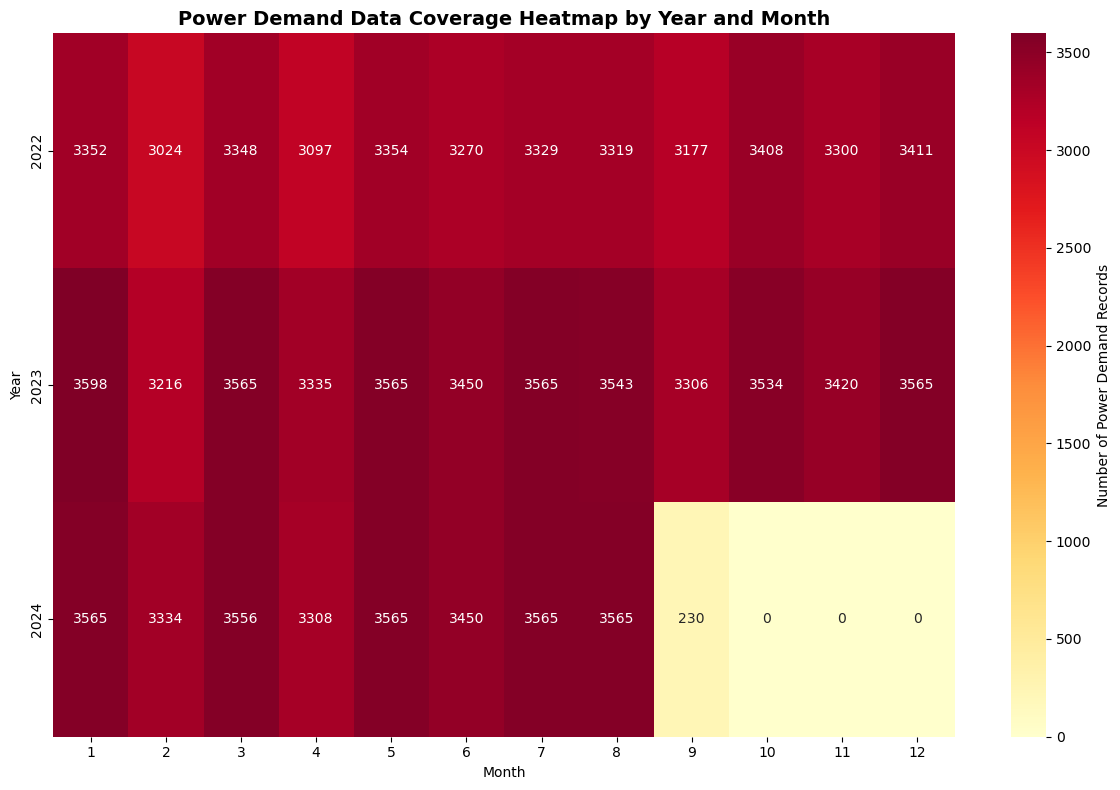

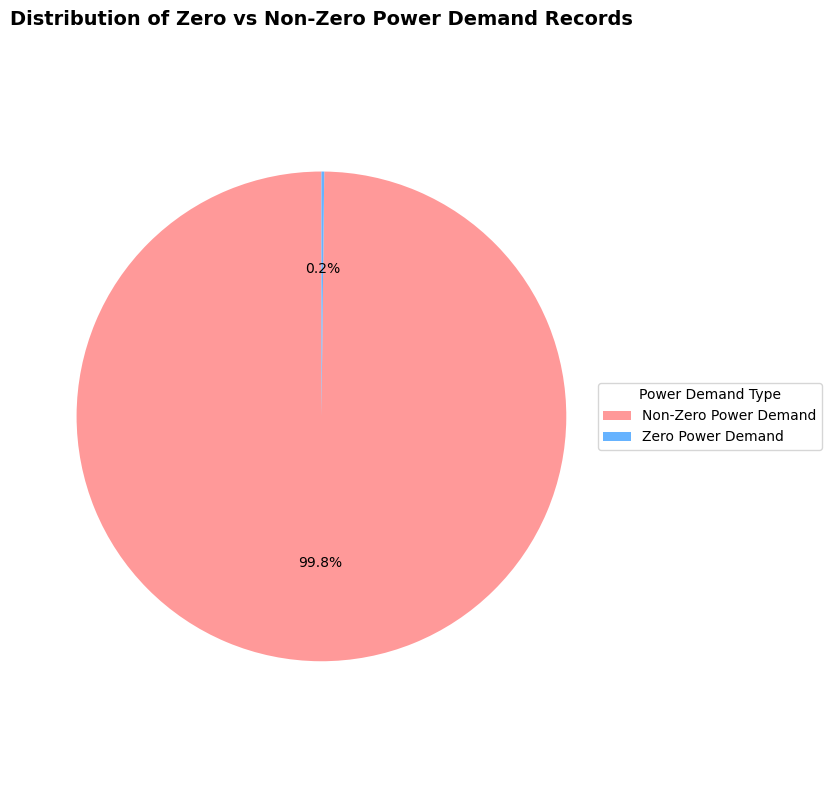

Zero power demand records: 200 (0.2%)
Non-zero power demand records: 108,989 (99.8%)


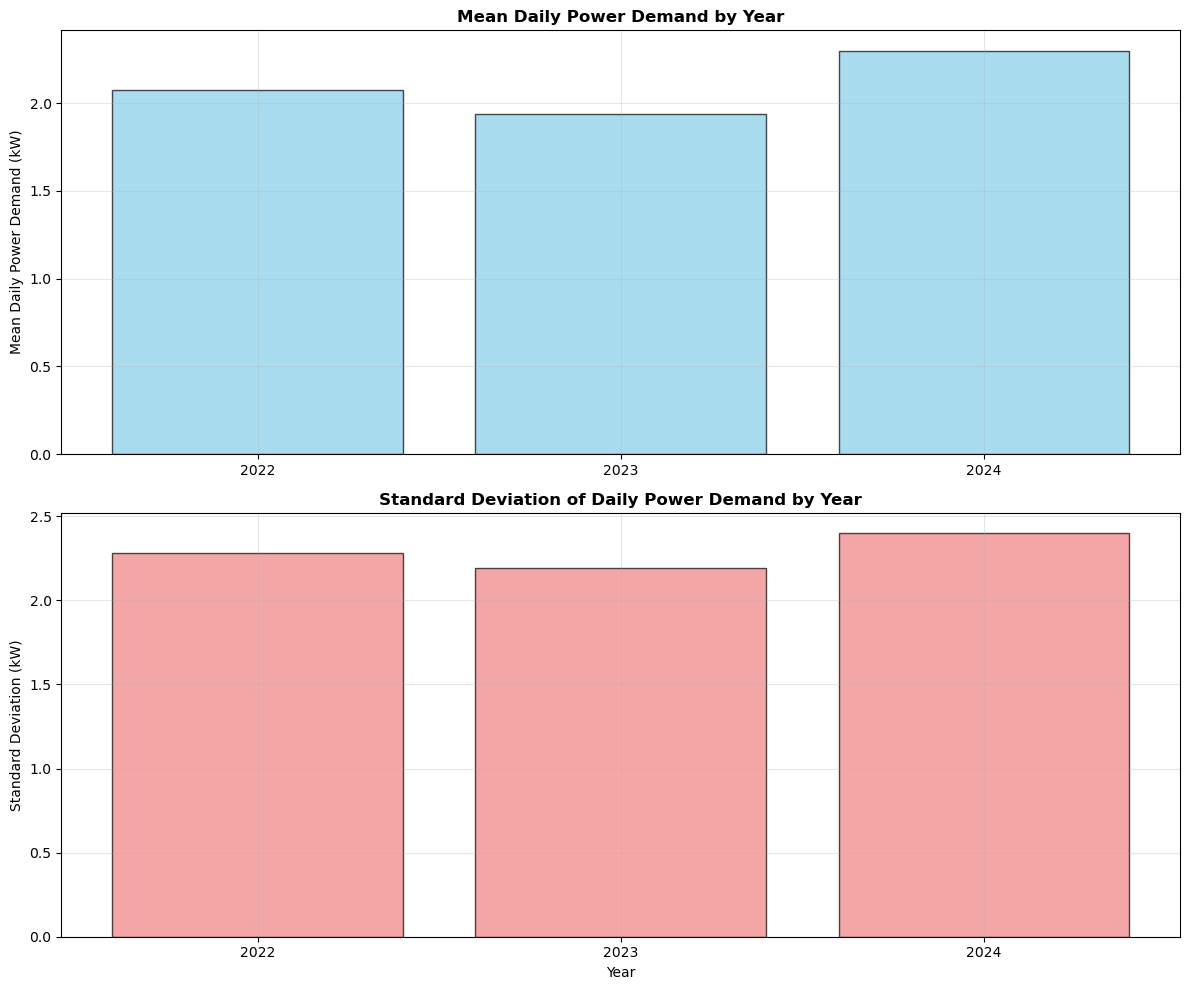

Seasonal averages:
season
Summer    0.7
Autumn    2.2
Winter    3.1
Spring    2.2
Name: daily_power_total, dtype: float64


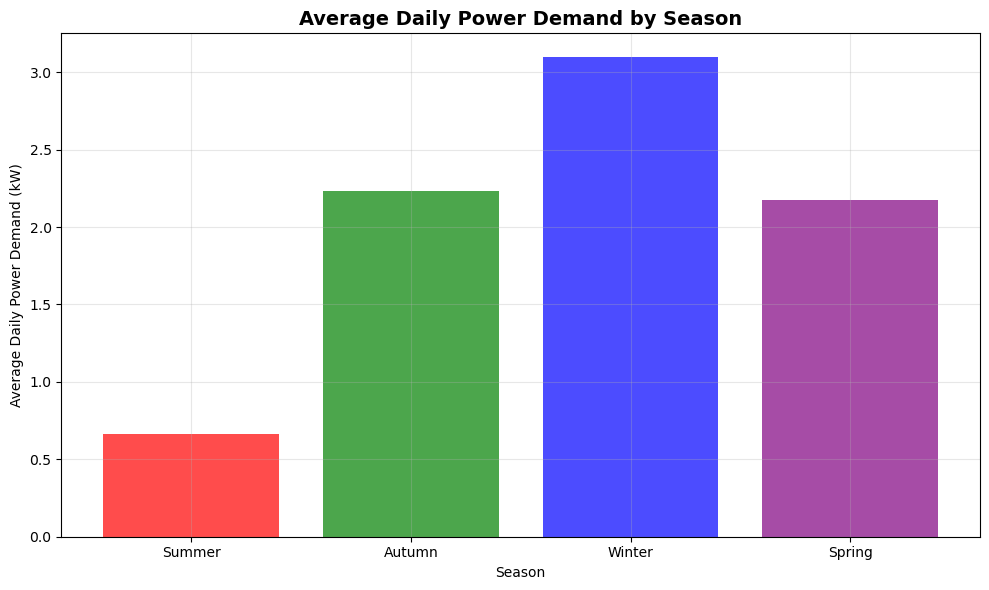

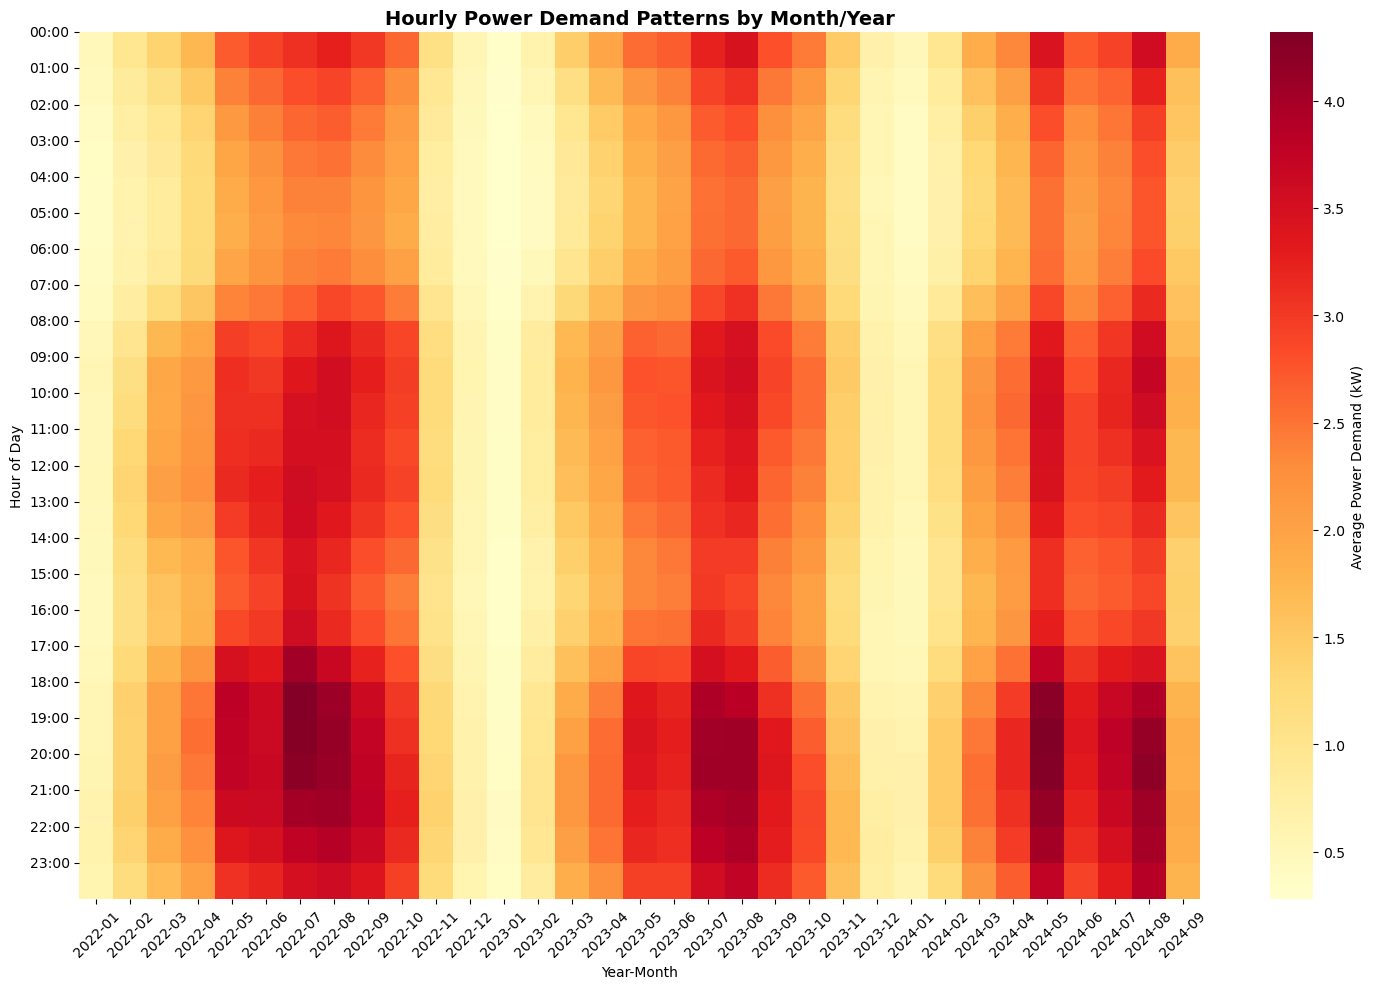

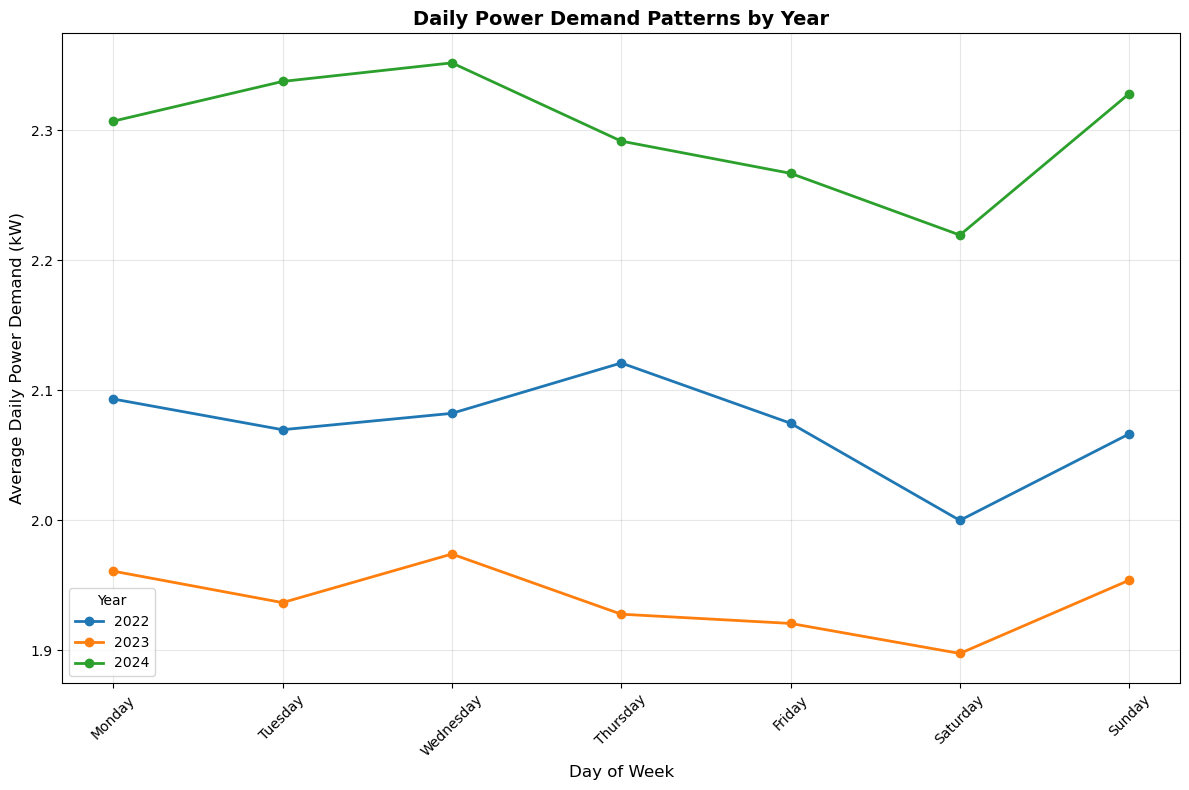

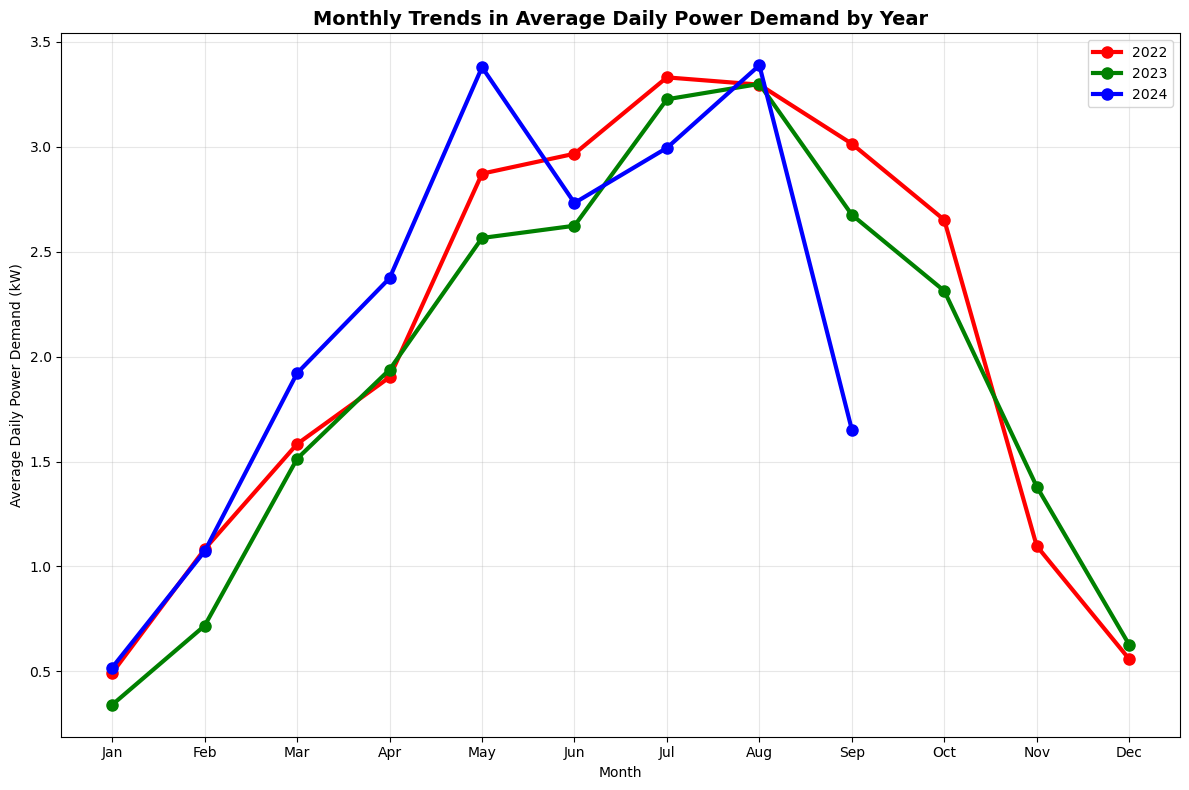

Annual averages:
year
2022    2.1
2023    1.9
2024    2.3
Name: daily_power_total, dtype: float64


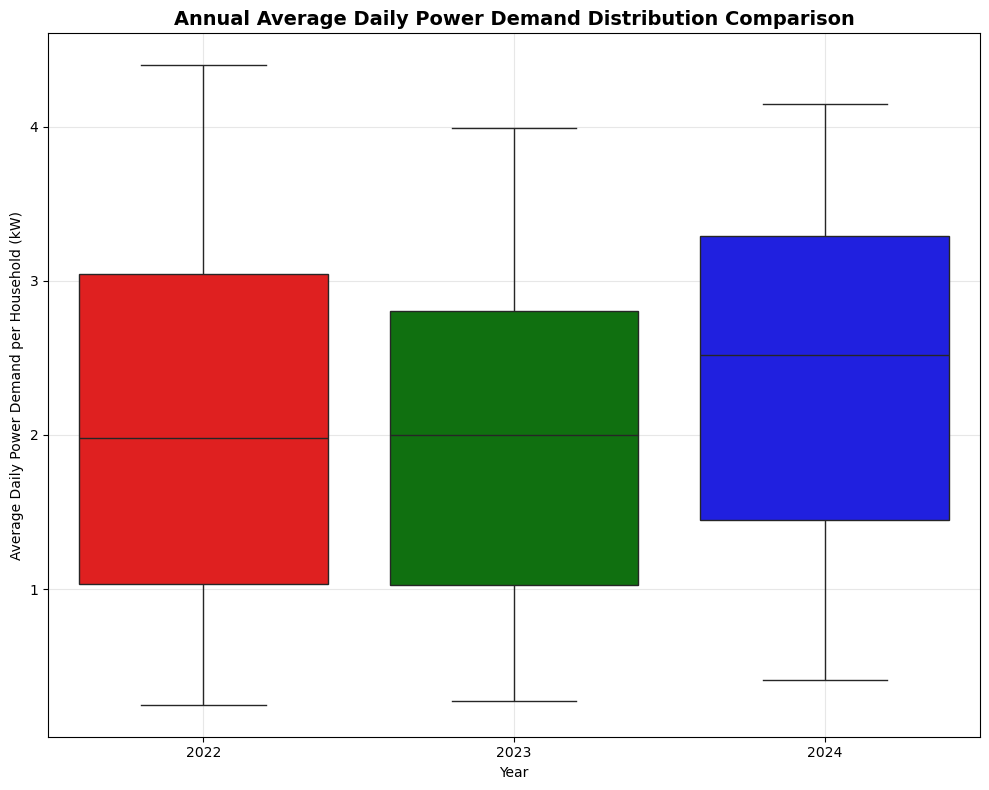

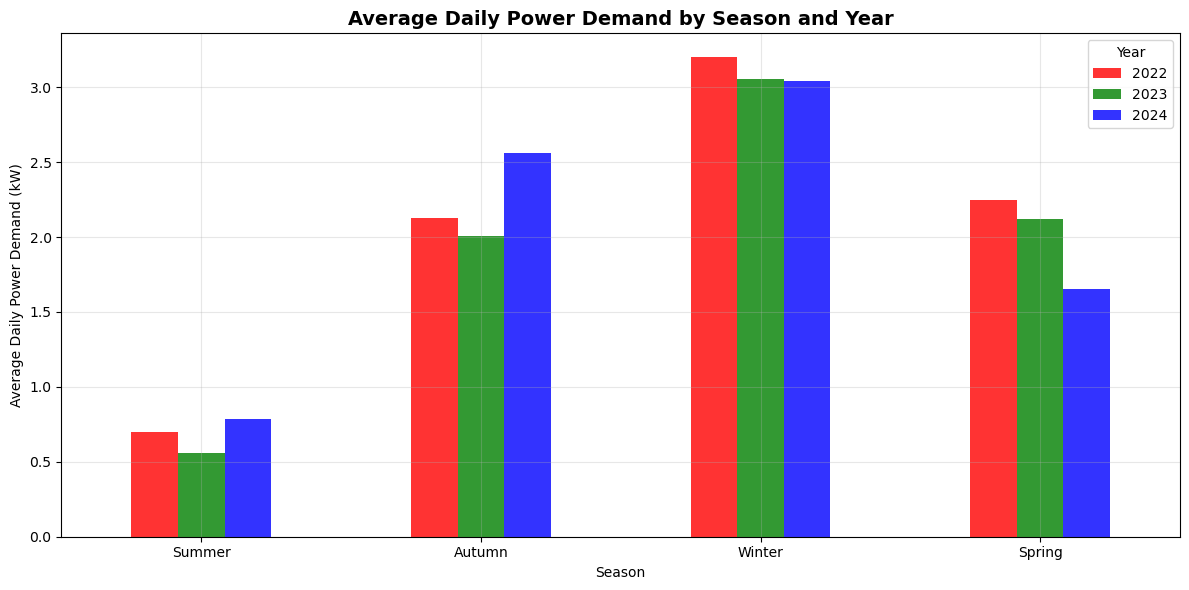

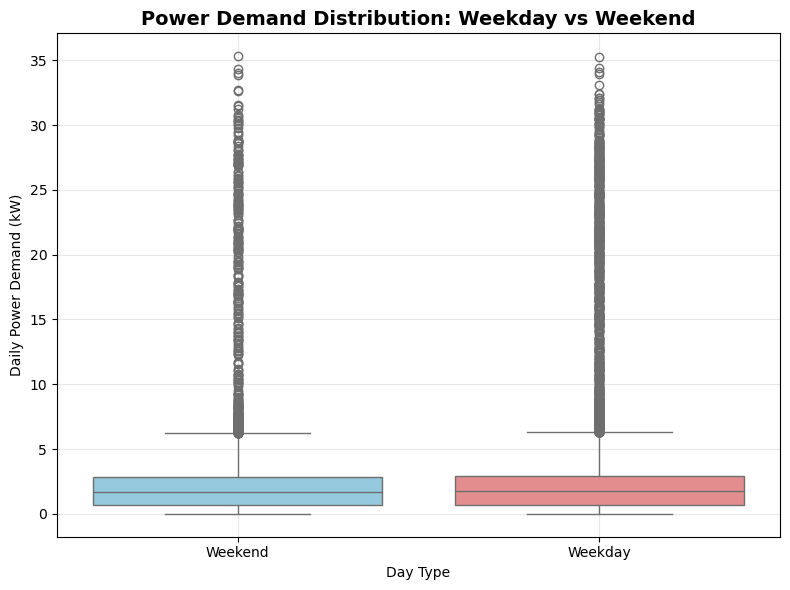

Working with POWER DEMAND (kW)
Daily power range: 0.0 to 35.3 kW

=== POWER DEMAND CLASSIFICATION ===
Term Time: 63583 records (538 actual days)
Semester Break: 36499 records (309 actual days)
Mid-Semester Break: 7982 records (67 actual days)
Public Holiday: 1125 records (9 actual days)

=== POWER DEMAND ANALYSIS (kW) ===
Term Time           :    2.7 ±   2.4 kW/day (538 days)
Public Holiday      :    2.7 ±   2.3 kW/day (  9 days)
Mid-Semester Break  :    2.1 ±   2.1 kW/day ( 67 days)
Semester Break      :    1.0 ±   1.5 kW/day (309 days)


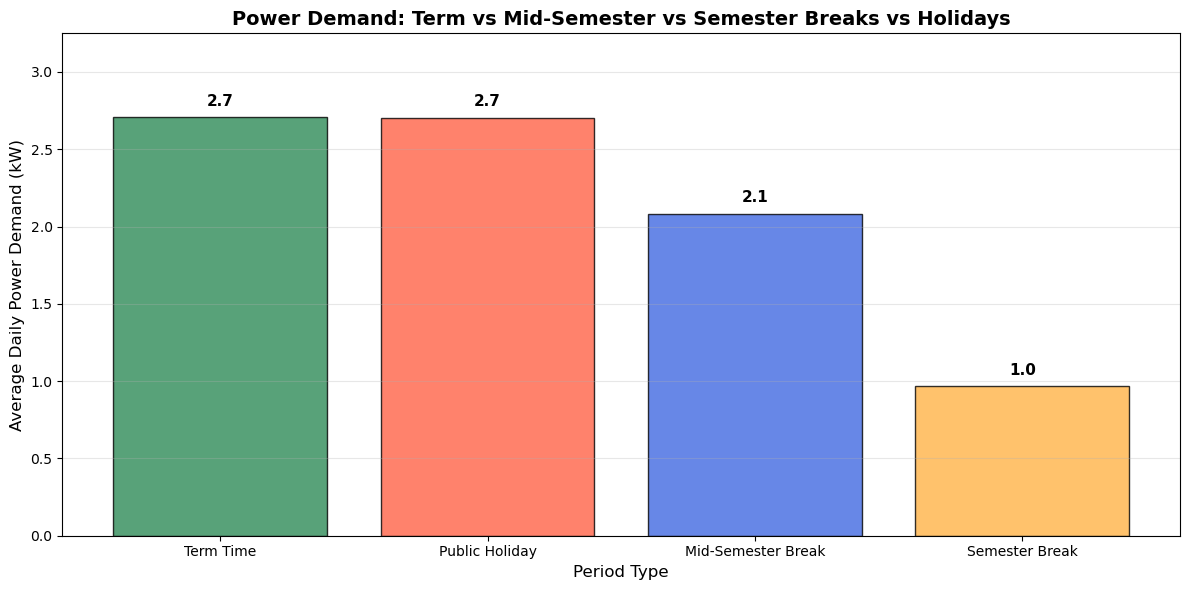

STATISTICAL SIGNIFICANCE TESTS FOR POWER DEMAND PATTERNS


1. SEASONAL POWER DEMAND COMPARISON
Kruskal-Wallis Test (Seasonal Comparison):
  H-statistic: 260.3549
  p-value: 3.77e-56
  Result: SIGNIFICANT seasonal difference

Seasonal Power Demand Statistics:
  Summer: 0.66 ± 0.83 kW/day (n=118.0 households)
  Autumn: 2.21 ± 1.83 kW/day (n=118.0 households)
  Winter: 3.07 ± 2.32 kW/day (n=118.0 households)
  Spring: 2.18 ± 1.74 kW/day (n=118.0 households)


2. WEEKDAY vs WEEKEND POWER DEMAND COMPARISON
Mann-Whitney U Test (Weekday vs Weekend):
  U-statistic: 7249.0000
  p-value: 5.85e-01
  Result: NOT SIGNIFICANT difference

Weekday vs Weekend Statistics:
  Weekdays: 2.08 ± 1.67 kW/day (n=118 households)
  Weekends: 2.04 ± 1.68 kW/day (n=118 households)
  Difference: 0.04 kW/day (1.8%)


3. ACADEMIC PERIOD POWER DEMAND COMPARISON
Kruskal-Wallis Test (Academic Period Comparison):
  H-statistic: 227.8941
  p-value: 3.95e-49
  Result: SIGNIFICANT difference between periods

Academic Period

In [324]:
df = run_all_plots()